* In this kernel we are going to use ImageDataGenerator to load images in batches of 8, and adding augmentation.
* Augmentations - rotation, zoomimg, horizontal and vertical flips.
* *CROPPING IMAGE* : We will also use image cropping to crop the extra black part in the images in the training data.
* We will use the DenseNet121 model.

Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from keras.applications import DenseNet121
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
import csv
import gc
import cv2
from tqdm import tqdm_notebook

train_csv = "../input/aptos2019-blindness-detection/train.csv"
test_csv = "../input/aptos2019-blindness-detection/test.csv"
train_dir = "../input/aptos2019-blindness-detection/train_images/"
test_dir = "../input/aptos2019-blindness-detection/test_images/"

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
df_train = pd.read_csv(train_csv) 
size = 256,256 # input image size
df_test = pd.read_csv(test_csv)
NUM_CLASSES = df_train['diagnosis'].nunique()
print(NUM_CLASSES)

5


#### CROPPING FUNCTION :

In [3]:
# cropping function (uses edge detection to crop images)
def get_cropped_image(image):
    img = cv2.blur(image,(2,2))
    #gry = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    slice1Copy = np.uint8(img)
    canny = cv2.Canny(slice1Copy, 0, 50)
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)
    cropped_img = img[y1:y2, x1:x2]
    cropped_img = cv2.resize(cropped_img, size)
    return cropped_img

Demonstration of above function :


In [4]:
'''sample_to_show = ['07419eddd6be.png','0124dffecf29.png']

def get_cropped_image_demo(image):
    img = cv2.blur(image,(2,2))
    slice1Copy = np.uint8(img)
    canny = cv2.Canny(slice1Copy, 0, 50)
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)
    cropped_img = img[y1:y2, x1:x2]
    return np.array(cropped_img)

names = []
samples = []
cropped_images = []
for i in sample_to_show:
    path = train_dir + str(i)
    img_ = cv2.imread(path)
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    samples.append(img_)
    cropped_ = get_cropped_image_demo(img_)
    cropped_images.append(cropped_)
    
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(2,2,1)
ax1.title.set_text('original image'), ax1.axis("off"), plt.imshow(samples[0])
ax2 = fig.add_subplot(2,2,2)
ax2.title.set_text('cropped image'), ax2.axis("off"), plt.imshow(cropped_images[0])
ax3 = fig.add_subplot(2,2,3)
ax3.title.set_text('original image'), ax3.axis("off"), plt.imshow(samples[1])
ax4 = fig.add_subplot(2,2,4)
ax4.title.set_text('cropped image'), ax4.axis("off"), plt.imshow(cropped_images[1]);'''

'sample_to_show = [\'07419eddd6be.png\',\'0124dffecf29.png\']\n\ndef get_cropped_image_demo(image):\n    img = cv2.blur(image,(2,2))\n    slice1Copy = np.uint8(img)\n    canny = cv2.Canny(slice1Copy, 0, 50)\n    pts = np.argwhere(canny>0)\n    y1,x1 = pts.min(axis=0)\n    y2,x2 = pts.max(axis=0)\n    cropped_img = img[y1:y2, x1:x2]\n    return np.array(cropped_img)\n\nnames = []\nsamples = []\ncropped_images = []\nfor i in sample_to_show:\n    path = train_dir + str(i)\n    img_ = cv2.imread(path)\n    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)\n    samples.append(img_)\n    cropped_ = get_cropped_image_demo(img_)\n    cropped_images.append(cropped_)\n    \nfig = plt.figure(figsize = (5,5))\nax1 = fig.add_subplot(2,2,1)\nax1.title.set_text(\'original image\'), ax1.axis("off"), plt.imshow(samples[0])\nax2 = fig.add_subplot(2,2,2)\nax2.title.set_text(\'cropped image\'), ax2.axis("off"), plt.imshow(cropped_images[0])\nax3 = fig.add_subplot(2,2,3)\nax3.title.set_text(\'original image\'),

Loading Images :

In [5]:
def load_image(path):
    img=cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    img = cv2.resize(cv2.imread(path), size)
    img = get_cropped_image(img)
    return img

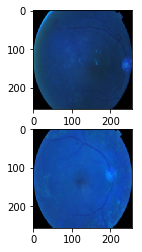

In [6]:
import matplotlib.pyplot as plt
import PIL     #df.at[2, 'StartDate']

img1 = load_image(train_dir+str(df_train.at[0,"id_code"])+str(".png"))
img2 = load_image(train_dir+str(df_train.at[1,"id_code"])+str(".png"))

#fig, ax = plt.subplots(nrows=2, ncols=2)

plt.figure(1)
plt.subplot(211)
plt.imshow(img1)

plt.subplot(212)
plt.imshow(img2)
plt.show()
 

In [7]:
training_paths = [train_dir + str(x) + str(".png") for x in df_train["id_code"]]
images = np.empty((len(df_train), 256,256,3), dtype = np.uint8)
for i, path in tqdm_notebook(enumerate(training_paths)):
    images[i,:,:,:] = load_image(path)

In [8]:
print(len(images))
#plt.show()

3662


In [9]:
labels = df_train["diagnosis"].values.tolist()
labels = keras.utils.to_categorical(labels)

In [10]:
images, x_val, labels, y_val = train_test_split(images, labels, test_size = 0.15)

#### ImageDataGenerator (Training data)

In [11]:
train_aug = ImageDataGenerator(horizontal_flip = True,
                               zoom_range = 0.25,
                               rotation_range = 60,
                               vertical_flip = True,
                              shear_range=0.1)

train_generator = train_aug.flow(images, labels, batch_size = 8)

In [12]:
val_aug=train_aug.flow(x_val,y_val,batch_size=8)

MODEL:

In [13]:
'''input_layer = Input(shape = (256,256,3))
base_model = DenseNet121(include_top = False, input_tensor = input_layer, weights = "../input/densenet-keras/DenseNet-BC-121-32-no-top.h5")
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
out = Dense(5, activation = 'softmax')(x)

model = Model(inputs = input_layer, outputs = out)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-13-dafcea617cef>, line 7)

OTHER MODEL COPIED FROM APTOS 2019: DenseNet modified Keras Starter(15-12)

In [14]:
BATCH_SIZE = 32
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 256
WIDTH = 256
CANAL = 3
N_CLASSES = 5
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [15]:
def build_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, 
                                       include_top=False,
                                       input_tensor=input_tensor)
    base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model


In [16]:
from keras import optimizers, applications
from keras.models import Model
model = build_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)
model.summary()

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [17]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=['accuracy'])

In [18]:
#kappa_metrics = Metrics()
history = model.fit_generator(
    train_generator,
    steps_per_epoch=images.shape[0] / 8,
    epochs=8,
    validation_data=(x_val, y_val),
    callbacks=callback_list
)

Epoch 1/8
389/389 [==============================] - 81s 208ms/step - loss: 0.8669 - acc: 0.6864 - val_loss: 0.7106 - val_acc: 0.7473
Epoch 2/8
389/389 [==============================] - 63s 162ms/step - loss: 0.6515 - acc: 0.7596 - val_loss: 0.6314 - val_acc: 0.7800
Epoch 3/8
389/389 [==============================] - 62s 160ms/step - loss: 0.6293 - acc: 0.7670 - val_loss: 0.5231 - val_acc: 0.7982
Epoch 4/8
389/389 [==============================] - 62s 160ms/step - loss: 0.5605 - acc: 0.7876 - val_loss: 0.6374 - val_acc: 0.7709
Epoch 5/8
389/389 [==============================] - 63s 161ms/step - loss: 0.5492 - acc: 0.8059 - val_loss: 0.5769 - val_acc: 0.8000
Epoch 6/8
389/389 [==============================] - 62s 161ms/step - loss: 0.5103 - acc: 0.8046 - val_loss: 0.5881 - val_acc: 0.8018

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 7/8
389/389 [==============================] - 63s 161ms/step - loss: 0.4548 - acc: 0.8332 - val_loss: 0.4968

In [19]:
model.save('densenet.h5')

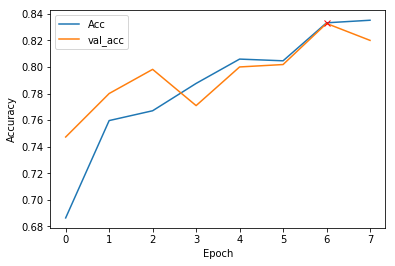

In [20]:
accu = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_acc'])
plt.plot(np.argmax(history.history["val_acc"]), np.max(history.history["val_acc"]), marker="x", color="r",
         label="best model")
plt.show()

In [21]:
from tqdm import tqdm
(eval_loss, eval_accuracy) = tqdm(
    model.evaluate_generator(generator=val_aug, steps=201, pickle_safe=False))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(generator=<keras_pre..., steps=201, use_multiprocessing=False)`
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 2/2 [00:00<00:00, 2795.27it/s]

[INFO] accuracy: 81.30%
[INFO] Loss: 0.525597987710028


ORIGINAL CODE:

In [22]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input
from keras.activations import softmax
from keras.activations import elu
from keras.activations import relu
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from tqdm import tqdm
from keras.layers import LeakyReLU


def create_resnet(img_dim, CHANNEL, n_class):
    input_tensor = Input(shape=(256, 256, 3))
    base_model = ResNet50(include_top=False, input_tensor=input_tensor,weights='../input/resnet50weightsfile/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    #base_model.load_weights('../input/ResNet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(2048)(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.3)(x)
    #x.add(LeakyReLU(alpha=0.1))
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.3)(x)
    #x.add(LeakyReLU(alpha=0.1))
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    model_resnet = Model(input_tensor, output_layer)

    return model_resnet


model_resnet = create_resnet(256, 3, NUM_CLASSES)

In [23]:
for layers in model_resnet.layers:
    layers.trainable = True

In [24]:
lr = 1e-3
optimizer = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True) 

es = EarlyStopping(monitor='val_loss', mode='min', patience = 5, restore_best_weights = True)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience = 2, factor = 0.5, min_lr=1e-6)
    
callback_list = [es, rlrop]

model_resnet.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"]) 

This kernel helped me choose the model parameters, and callbacks - [APTOS Blindness Detection - EDA and Keras ResNet50](https://www.kaggle.com/dimitreoliveira/aptos-blindness-detection-eda-and-keras-resnet50?scriptVersionId=16639594)

In [25]:
h=model_resnet.fit_generator(generator = train_generator, steps_per_epoch = len(train_generator), epochs = 20, validation_data = (x_val, y_val), callbacks = callback_list)

Epoch 1/20
389/389 [==============================] - 78s 199ms/step - loss: 1.5910 - acc: 0.5151 - val_loss: 1.0448 - val_acc: 0.6600
Epoch 2/20
389/389 [==============================] - 63s 162ms/step - loss: 1.1191 - acc: 0.6131 - val_loss: 0.8757 - val_acc: 0.7109
Epoch 3/20
389/389 [==============================] - 63s 162ms/step - loss: 0.9899 - acc: 0.6546 - val_loss: 0.7333 - val_acc: 0.7582
Epoch 4/20
389/389 [==============================] - 63s 161ms/step - loss: 0.8584 - acc: 0.6931 - val_loss: 0.7153 - val_acc: 0.7636
Epoch 5/20
389/389 [==============================] - 63s 162ms/step - loss: 0.8437 - acc: 0.6967 - val_loss: 0.6516 - val_acc: 0.7818
Epoch 6/20
389/389 [==============================] - 63s 161ms/step - loss: 0.7795 - acc: 0.7195 - val_loss: 0.5698 - val_acc: 0.7709
Epoch 7/20
389/389 [==============================] - 64s 165ms/step - loss: 0.7293 - acc: 0.7333 - val_loss: 0.6337 - val_acc: 0.7764
Epoch 8/20
389/389 [==============================] - 6

In [26]:
del train_generator, images
gc.collect()

5

In [27]:
model_json = model_resnet.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_resnet.save_weights("model2.h5")
print("Saved model to disk")

Saved model to disk


In [28]:
h.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

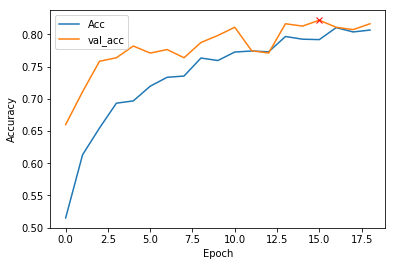

In [29]:
accu = h.history['acc']
val_acc = h.history['val_acc']

plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_acc'])
plt.plot(np.argmax(h.history["val_acc"]), np.max(h.history["val_acc"]), marker="x", color="r",
         label="best model")
plt.show()

In [30]:
from tqdm import tqdm
(eval_loss, eval_accuracy) = tqdm(
    model.evaluate_generator(generator=val_aug, steps=201, pickle_safe=False))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(generator=<keras_pre..., steps=201, use_multiprocessing=False)`
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 2/2 [00:00<00:00, 4793.49it/s]

[INFO] accuracy: 80.84%
[INFO] Loss: 0.5305716325370139


TEST:

In [31]:
test_df = pd.read_csv(test_csv)
test_paths = [test_dir + str(x) + str(".png") for x in test_df["id_code"]]
test_images = np.empty((len(test_df), 256,256,3), dtype = np.uint8)
for i, path in tqdm_notebook(enumerate(test_paths)):
    test_images[i,:,:,:] = cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), size)

#### PREDICTION

In [32]:
predprobs = model_resnet.predict(test_images)

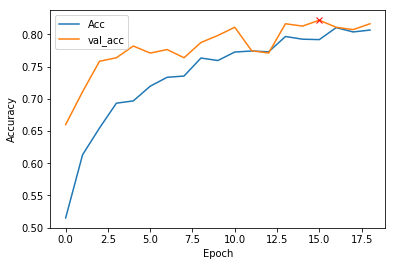

In [33]:
accu = h.history['acc']
val_acc = h.history['val_acc']

plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_acc'])
plt.plot(np.argmax(h.history["val_acc"]), np.max(h.history["val_acc"]), marker="x", color="r",
         label="best model")
plt.show()

In [34]:
predictions = []
for i in predprobs:
    predictions.append(np.argmax(i)) 

Submission :

In [35]:
id_code = test_df["id_code"].values.tolist()
subfile = pd.DataFrame({"id_code":id_code, "diagnosis":predictions})
subfile.to_csv('submission.csv',index=False)

#TESTING WITH IDRID DATASET

In [36]:
#loaded_model.load_weights("..input/MY model/model2.h5")
#print("Loaded model from disk")

In [37]:
from keras.models import load_model
model = load_weights('../input/My model/model2.h5')

NameError: name 'load_weights' is not defined

In [38]:
import pandas as pd
messidor_data = pd.read_csv("../input/messidor2-dr-grades/messidor_data.csv")

FileNotFoundError: [Errno 2] File b'../input/messidor2-dr-grades/messidor_data.csv' does not exist: b'../input/messidor2-dr-grades/messidor_data.csv'